# Projection

Since there were so many complaints and locations, a projection from Offense to Location was created. Using the query below I created the relationship MULTIPLE_COMPLAINTS which is a relationship between only offenses to locations with more than one complaint. I am storing a relationship property 'first_complaint' that indicates the earliest a complaint of that type of offense was committed at that location and ‘previous_complaints’ which is the amount of previous complaints.

In [26]:
from py2neo import Graph

In [27]:
graph = Graph("bolt://localhost:7687", auth=("neo4j", "SFi5gS09lHiMfu9VuJTg"))

The following query was run afterwards was to delete relationships that did not have multiple complaints at that location.

A graph is created that uses Location and Offense nodes and MULTIPLE_COMPLAINTS relationship projection that is undirected, since the link prediciton algorithm must have relationship projected as UNDIRECTED.

# Test and Training Data

In [ ]:
call gds.alpha.ml.splitRelationships.mutate('loc_offenses',{
    remainingRelationshipType: 'OUTER_TRAIN',
    holdoutRelationshipType: 'TEST',
    holdoutFraction: 0.1,
    negativeSamplingRatio: 1.0,
    randomSeed: 1
})

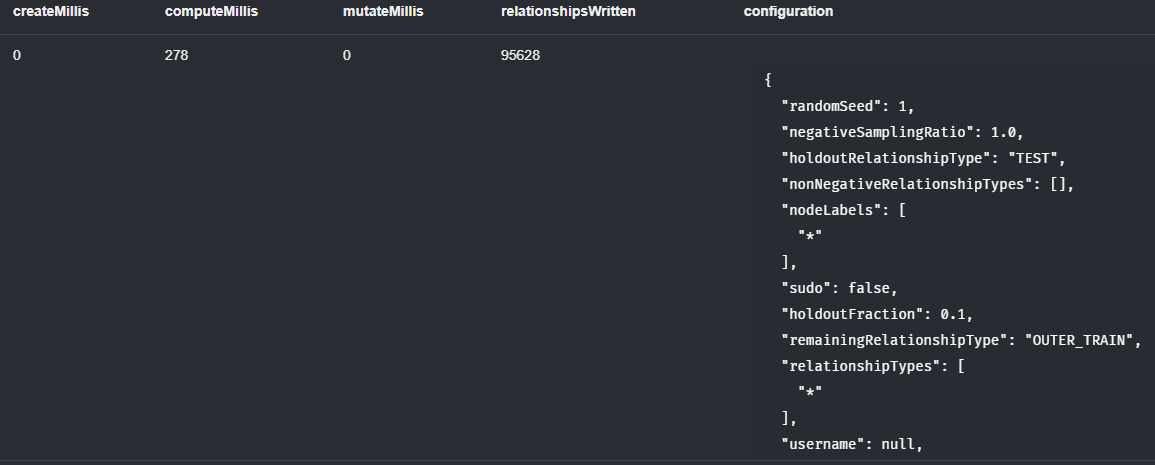

In [ ]:
call gds.alpha.ml.splitRelationships.mutate('loc_offenses',{
    relationshipTypes: ['OUTER_TRAIN'],
    remainingRelationshipType: 'EMBEDDING_GRAPH',
    holdoutRelationshipType: 'TRAIN',
    holdoutFraction: 0.1,
    negativeSamplingRatio: 1.0,
    randomSeed: 1
})

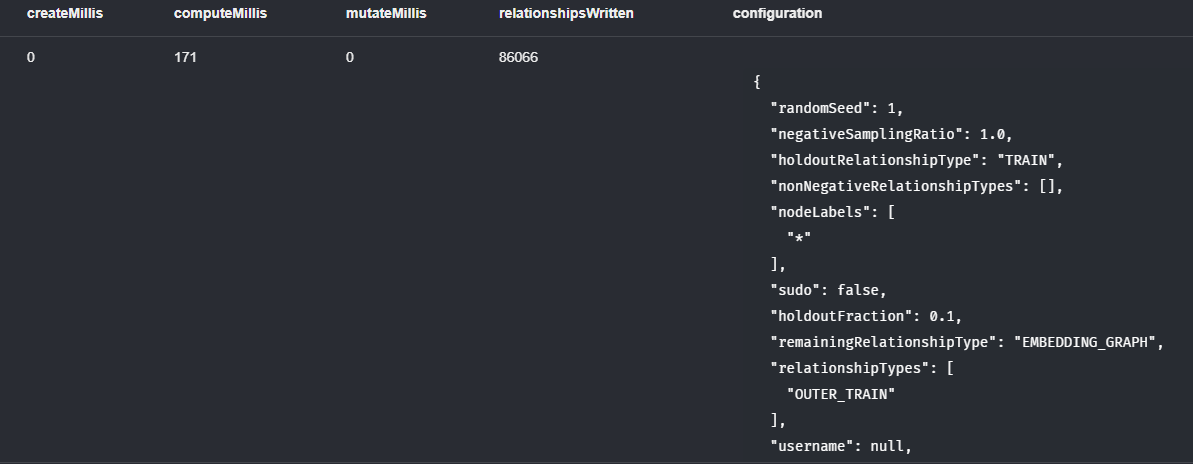

In [ ]:
call gds.beta.fastRPExtended.mutate('loc_offenses', {
    relationshipTypes: ['EMBEDDING_GRAPH'],
    mutateProperty: 'frp',
    embeddingDimension: 512,
    propertyDimension: 256,
    randomSeed: 1
})

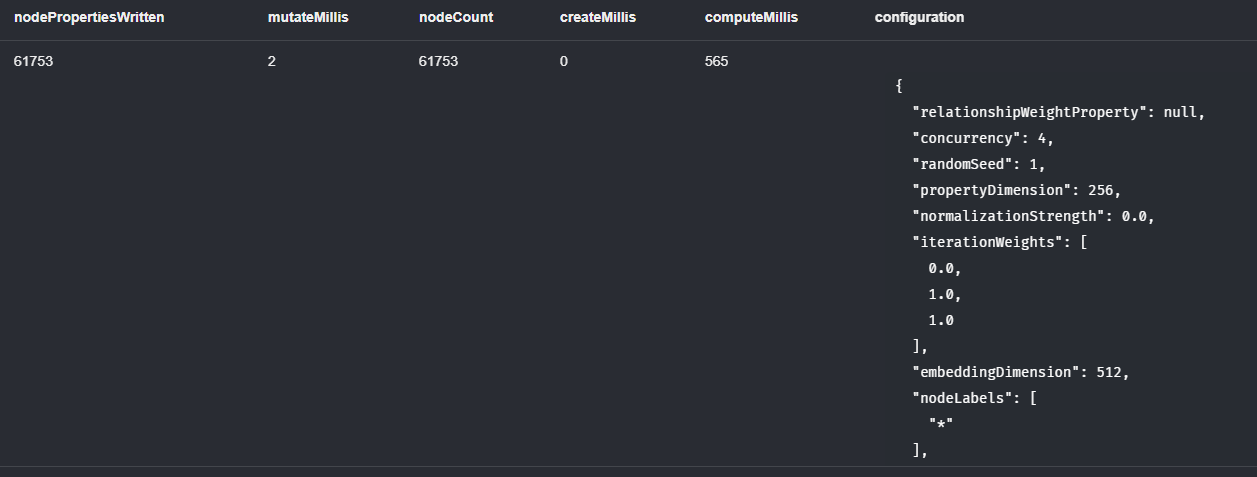

In [ ]:
call gds.alpha.ml.linkPrediction.train('loc_offenses',{
    trainRelationshipType: 'TRAIN',
    testRelationshipType: 'TEST',
    modelName: 'model',
    featureProperties: ['frp'],
    validationFolds: 5,
    negativeClassWeight: 1.0,
    randomSeed: 1,
    concurrency: 4,
    params: [
        {penalty: 0.0001, maxEpochs: 500, linkFeatureCombiner: 'HADAMARD'},
        {penalty: 1.0, maxEpochs: 500, linkFeatureCombiner: 'HADAMARD'},
        {penalty: 10000.0, maxEpochs: 500, linkFeatureCombiner: 'HADAMARD'},
        {penalty: 0.0001, maxEpochs: 500, linkFeatureCombiner: 'L2'},
        {penalty: 1.0, maxEpochs: 500, linkFeatureCombiner: 'L2'},
        {penalty: 10000.0, maxEpochs: 500, linkFeatureCombiner: 'L2'},
        {penalty: 0.0001, maxEpochs: 500, linkFeatureCombiner: 'COSINE'},
        {penalty: 1.0, maxEpochs: 500, linkFeatureCombiner: 'COSINE'},
        {penalty: 10000.0, maxEpochs: 500, linkFeatureCombiner: 'COSINE'}
    ]
})
yield modelInfo
return modelInfo.metrics.AUCPR.test as test_auc, modelInfo.metrics.AUCPR.outerTrain as train_auc, modelInfo.bestParameters as best_parameters

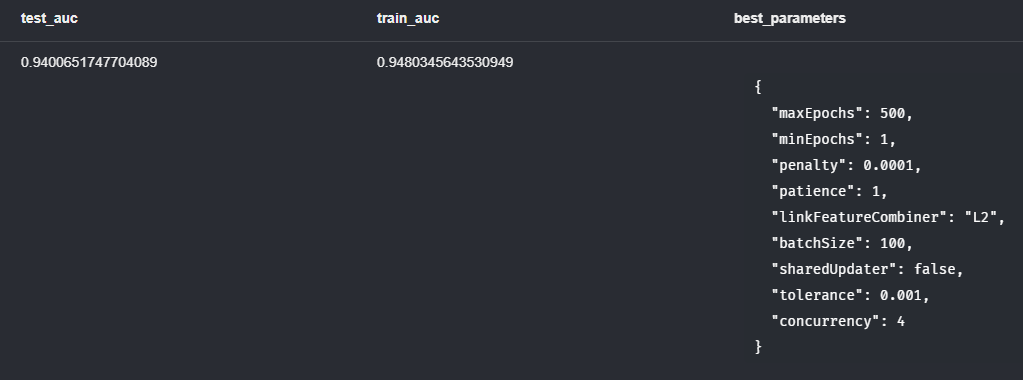

The prediction method is then called to make predictions on future relationships using the trained model from the previous step.  A new relationship is created called FUTURE_COMPLAINTS_PREDICTED, containing the relationships from the model.  It includes a relationship property ‘probability’ containing the probability of the prediction.  For the purpose of time, on the top 50 results were generated and a threshold of .3 was used to filter probabilities.  This is a very intensive step as it runs the entire prediction across your entire graph.  Use the prediction method below to over 48 minutes to complete.

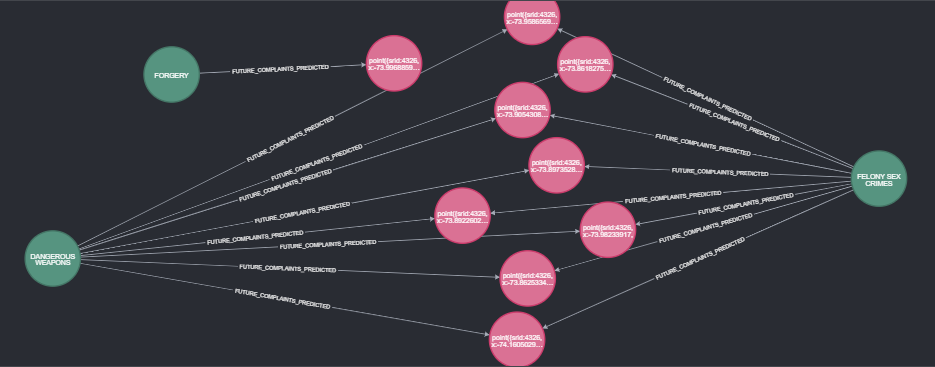

In [35]:
from ipyleaflet import Map, basemaps, WidgetControl, Marker, Polyline, AwesomeIcon, LayersControl
import ipywidgets as widgets

In [36]:
center = [40.7128, -74.0060]
zoom = 11

In [37]:
pred_map = Map(basemap=basemaps.CartoDB.DarkMatter, center=center, zoom=zoom, layout=widgets.Layout(width='100%', height='800px'))

In [38]:
def add_marker(x):
    coord = (x['latitude'], x['longitude'])
    
    icon1 = AwesomeIcon(
        name='bullseye',
        marker_color='red',
        icon_color='black',
        spin=False)
    
    marker = Marker(icon=icon1,location=coord, 
                    title='Location: ' + str(coord)+'\n' + 'Probability: ' +str(x['probability']) +'\n' +'Offense: ' + str(x['offense']), 
                    draggable=False)
    pred_map.add_layer(marker)

In [39]:
pred_query = "match (o:Offense)-[f:FUTURE_COMPLAINTS_PREDICTED]->(l:Location) \
return l.latitude as latitude, \
l.longitude as longitude, \
l.location_id as location_id, \
f.probability as probability, \
o.offense as offense"

In [40]:
pred_df = graph.run(pred_query).to_data_frame()

In [41]:
pred_df.apply(add_marker, axis=1)

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
dtype: object

In [42]:
pred_map

Map(center=[40.7128, -74.006], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…